In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
print(mavenn.__path__)
import logomaker
import seaborn as sns
import re

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local/mavenn']


**From Jared Winkelman's emails (20.12.22):**

Here are the data. Let me know if anything is confusing. There are three replicates in the sample column (KS112-KS114), p4 to p10 stand for reads at position 4 to position 10 of the N10 region. There are 4 different treatments. We have always compared the 'All_end' to the 'PPP+P' and the 'OH+P' to the 'background'. If you have any quick questions you can email me or text me at 512-689-9468 and I will try to reply promptly. 


- "background" was made by direct ligation to 5’ Adaptor (will ligate to any 5' monophosphate-containing RNAs)
- "OH+P" = treatment with T4 PNK (kinase OH with P) followed by ligation to 5’ ad
- "PPP+P" = treatment with RNA polyphosphatase (trim beta and gamma P from 5’ end) followed by ligation to 5’ ad
- "All_end" = rna polyphosphatase treatment, then T4 PNK, and lastly followed by 5’ ad ligation 

In [2]:
# Load Bryce's data
data_df = pd.read_csv('data/Nano_RNA_in_vivo.csv')

# Rename columns and samples for added convenience
data_df.rename(columns={'DNA count':'DNA'}, inplace=True)
data_df['treatment'] = np.where(data_df['treatment']=='All_end', 'all', data_df['treatment'])
data_df['treatment'] = np.where(data_df['treatment']=='background', 'P', data_df['treatment'])

#Rename treatment and replicates
data_df['treatment'] = data_df['treatment'].map({'P':'none', 
                                                 'PPP+P':'RPP', 
                                                 'OH+P':'PNK', 
                                                 'all':'PNK+RPP'})
data_df['sample'] = data_df['sample'].map({'KS112':'rep1', 
                                           'KS113':'rep2', 
                                           'KS114':'rep3'})
data_df.head()

,N10,treatment,sample,DNA,p4,p5,p6,p7,p8,p9,p10
0,AAAAAAAAAA,PNK+RPP,rep1,18,0,0,0,0,0,0,0
1,AAAAAAAAAC,PNK+RPP,rep1,41,0,0,0,0,0,0,0
2,AAAAAAAAAG,PNK+RPP,rep1,38,0,0,0,0,0,0,0
3,AAAAAAAAAT,PNK+RPP,rep1,30,0,0,0,0,0,0,0
4,AAAAAAAACA,PNK+RPP,rep1,14,0,0,0,0,0,0,0


In [3]:
# Grab only 'RPP' from 'rep1'
replicate='rep1'
sample='RPP'
cols = [f'p{n}' for n in range(4,11)]
ix = (data_df['sample']==replicate) & (data_df['treatment']==sample)
df = data_df[ix].copy()

# Set index 
df.set_index('N10', inplace=True, drop=True)

# Drop unneeded columns
df = df[cols]

# Remove rows with zero sum
df = df[df.sum(axis=1)>=1]
df

,p4,p5,p6,p7,p8,p9,p10
N10,,,,,,,
AAAAAAAAAC,0,0,0,1,0,0,1
AAAAAAAAAT,0,0,0,1,0,0,0
AAAAAAACAG,0,0,0,1,0,0,0
AAAAAAACAT,0,0,0,2,0,0,0
AAAAAAAGAC,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...
TTTTTTTTGT,1,0,1,1,1,3,0
TTTTTTTTTA,1,2,0,0,0,0,1
TTTTTTTTTC,0,2,2,0,1,0,0


In [4]:
# Set training and testing sequences
N = len(df)
r = np.random.rand(N)
df.insert(loc=0, column='set', value='training')
df.loc[(r >= .2) & (r < .4), 'set'] = 'validation'
df.loc[(r < .2), 'set'] = 'test'
df.head()

,set,p4,p5,p6,p7,p8,p9,p10
N10,,,,,,,,
AAAAAAAAAC,training,0,0,0,1,0,0,1
AAAAAAAAAT,validation,0,0,0,1,0,0,0
AAAAAAACAG,training,0,0,0,1,0,0,0
AAAAAAACAT,test,0,0,0,2,0,0,0
AAAAAAAGAC,training,0,0,0,3,0,0,0


In [5]:
ix_test = (df['set'] == 'test')
x_test = df[ix_test].index.values
y_test = df[ix_test].iloc[:,1:].values

In [6]:
#x_test

# Multi-latent MPA regression

In [32]:
# Set x and y
ix = (df['set'] != 'test')
x_train = df[ix].index.values
y_train = df[ix].iloc[:,1:].values
validation_flags = df['set'][ix] == 'validation'
#L = len(x[0])
L = len(df.index[0])
Y = y_train.shape[1]

I_variational_list = []
val_I_variational_list = []


# Iterate over models with increasing latent nodes
#for number_latent_nodes in range(1,11,1):
    
# run each model multiple times to get average
#for trial_per_latent_nodes in range(5):
#print(number_latent_nodes)

number_latent_nodes = 3

# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='Multi_MPA',
                     number_latent_nodes=number_latent_nodes,
                     gpmap_type='additive',
                    )


In [33]:
model.get_nn().summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_labels_input (InputLay [(None, 47)]         0                                            
__________________________________________________________________________________________________
Sequence_only (Lambda)          (None, 40)           0           Sequence_labels_input[0][0]      
__________________________________________________________________________________________________
multi__additive_gp_map_layer_7  (None, 3)            123         Sequence_only[0][0]              
__________________________________________________________________________________________________
Labels_input (Lambda)           (None, 7)            0           Sequence_labels_input[0][0]      
___________________________________________________________________________________________

In [24]:

# Set data (takes a bit of time)
model.set_data(x=x_train,
               y=y_train, 
               validation_flags=validation_flags,
               verbose=False)

# Fit model
model.fit(learning_rate=.01,
          epochs=2, 
          batch_size=1000,
          linear_initialization=False,
          early_stopping=True,
          early_stopping_patience=10,
          verbose=True)

print(number_latent_nodes, model.I_variational(x_test,y_test)[0])
I_variational_list.append([number_latent_nodes, model.I_variational(x_test,y_test)[0]])
# Save model
#model.save(f'models/tss_{gpmap_type}')

Epoch 1/2
410/410 [==============================] - 10s 22ms/step - loss: 3723.0449 - I_var: 0.4845 - val_loss: 2006.3342 - val_I_var: 0.8270
Epoch 2/2
410/410 [==============================] - 9s 21ms/step - loss: 2006.5557 - I_var: 0.8385 - val_loss: 1964.5636 - val_I_var: 0.8451
Training time: 42.1 seconds
2 0.8463657107081157


In [39]:
I_variational_pairwise=[[1, 0.7535117899726131],
                        [2, 0.8525982534239986],
                        [3, 0.8835548197577694],
                        [4, 0.895468178922961],
                        [5, 0.9021944438765743],
                        [6, 0.9046283995459774],
                        [7, 0.9064166580985287]]

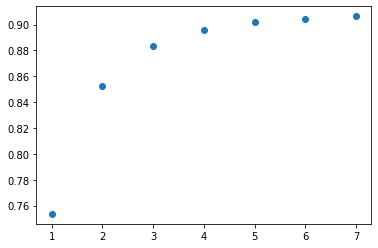

In [34]:
I_variational_list = np.loadtxt('I_variational_tss.txt').tolist()

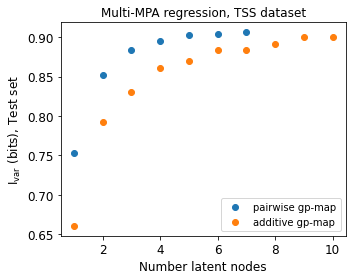

In [52]:
#model.I_variational(x_train,y_train)
plt.figure(figsize=(5,4))

plt.scatter(np.array(I_variational_pairwise)[:,0],np.array(I_variational_pairwise)[:,1], label='pairwise gp-map')
plt.scatter(np.array(I_variational_list)[:,0],np.array(I_variational_list)[:,1],label='additive gp-map')

# for mean_I_var_index in np.arange(1,11,1): 
#     plt.scatter(mean_I_var_index,np.mean(np.array(I_variational_list)[np.where(np.array(I_variational_list)[:,0]==mean_I_var_index)][:,1]),s=15,color='black')

#plt.scatter(mean_I_var_index,np.mean(np.array(I_variational_list)[np.where(np.array(I_variational_list)[:,0]==mean_I_var_index)][:,1]),s=15,color='black',label='mean - 5 trials (additive)')    
plt.ylabel('${\\rm I_{var}}$ (bits), Test set',fontsize=12)
plt.xlabel('Number latent nodes',fontsize=12)
plt.tick_params(labelsize=12)
plt.title('Multi-MPA regression, TSS dataset')
plt.legend()
plt.tight_layout()
#plt.savefig('Ivar_vs_latent_nodes.png',dpi=300,bbox_inches='tight')
plt.show()

In [12]:



# Create model
model = mavenn.Model(L=L, 
                     Y=Y,
                     alphabet='dna', 
                     regression_type='MPA', 
                     gpmap_type='additive')
                     #gpmap_kwargs=gpmap_kwargs)

# Set data (takes a bit of time)
model.set_data(x=x_train,
               y=y_train, 
               validation_flags=validation_flags,
               verbose=False)

# Fit model
model.fit(epochs=1,
          learning_rate=0.01,
          batch_size=1000,
          linear_initialization=False,
          early_stopping=True,
          early_stopping_patience=10,
         verbose=False)

print(1, model.I_variational(x_test,y_test))

    
# 1 (0.7111587336358192, 0.002174824311764514)
# 1 (0.7082753589448096, 0.0022425711861246193)    

1 (0.6061047520365459, 0.0022601121551577463)
